# Task 2: failed attempts

Attachment of the [project](https://github.com/valentinaboriano/Computer-Vision/blob/main/fruit_inspection.ipynb) for Computer Vision exam, University of Bologna

By Valentina Boriano (valentina.boriano@studio.unibo.it) and Pietro Fanti (pietro.fanti@studio.unibo.it)

## Preliminary operations and image imports

In [1]:
# Import libraries

import cv2
from matplotlib import pyplot as plt
import numpy as np
import statistics 

In [2]:
#will show images centered

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
FILENAMES2 = ["000004","000005"]
N2 = len(FILENAMES2)

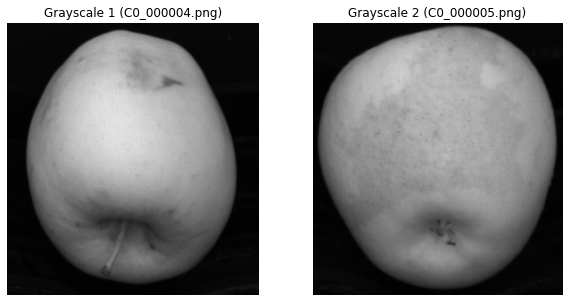

In [4]:
grayscales2 = []
plt.figure(figsize=(10, 5))

for i, name in enumerate(FILENAMES2):
    img = cv2.imread("../img/second task/C0_{0}.png".format(name), cv2.IMREAD_GRAYSCALE)
    grayscales2.append(img)
    plt.subplot(1,N2,i+1).axis("off")
    plt.title("Grayscale {0} (C0_{1}.png)".format(i+1, name))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Segmentation

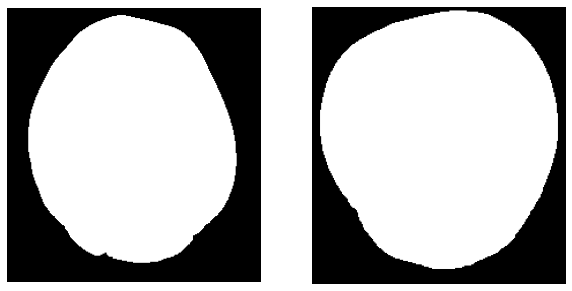

In [5]:
masks = []
fig = plt.figure(figsize=(10, 10))
for k, img in enumerate(grayscales2):
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret, mask = cv2.threshold(blur, 75, 1, cv2.THRESH_BINARY)
    # Flood-fill
    # Add 1 to each pixel, then set the background to 0. Having it set to 0 will simplify further calculus
    mask += 1
    cv2.floodFill(mask, None, (0,0), 0)
    m, n = mask.shape
    for i in range(m):
        for j in range(n):
            if mask[i,j] == 2:
                mask[i,j] = 1
    masks.append(mask)
    plt.subplot(1,2,k+1).axis("off")
    plt.imshow(mask, cmap='gray', vmin=0, vmax=1)
plt.show()

## Space color conversion

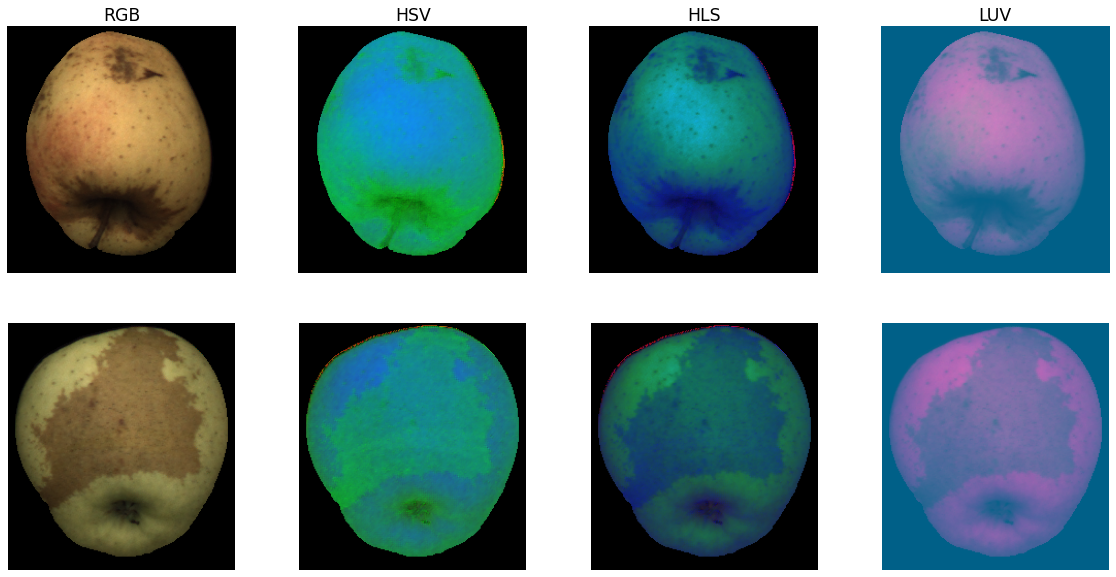

In [6]:
color_spaces = [(cv2.COLOR_BGR2RGB, "RGB"),
                (cv2.COLOR_BGR2HSV, "HSV"),
                (cv2.COLOR_BGR2HLS, "HLS"),
                (cv2.COLOR_BGR2Luv, "LUV")]
n_spaces = len(color_spaces)

colored_images = [[] for i in range(N2)]

pos = 1
plt.figure(figsize=(20, 10))
for i, name in enumerate(FILENAMES2):
    img_bgr = cv2.imread("../img/second task/C1_{0}.png".format(name))
    #apply mask
    for j in range(img_bgr.shape[2]):
        img_bgr[:,:,j] *= masks[i]
    for cs, cs_name in color_spaces:
        converted = cv2.cvtColor(img_bgr, cs)
        colored_images[i].append(converted)
        sub = plt.subplot(N2, n_spaces, pos)
        sub.axis("off")
        if pos <=4:
            sub.set_title(cs_name, size="xx-large")
        pos+= 1
        plt.imshow(converted)
plt.show()

(0,0,0) remains (0,0,0) in every color space, but in LUV, so we need to re-apply the mask to the LUV images:

In [7]:
for i in range(N2):
    for j in range(img_bgr.shape[2]):
        colored_images[i][3][:,:,j] *= masks[i]

In [8]:
foregrounds = [[] for i in range(N2)]

# Iterate over images
for i in range(N2):
    images = colored_images[i]
    #Iterate over color spaces
    for img in images:
        img = img[~np.all(img == 0, axis=2)]
        foregrounds[i].append(img)

We want to use second image as "training set" and the first one as validation, in order to get russet's mean color. In order to do that we will pick a central region from the second image and we will compute the mean color

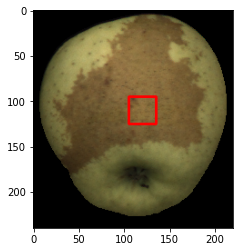

In [9]:
image = np.copy(colored_images[1][0])
m, n, _ = image.shape
side = 30
start_point = ((m-side)//2, (n-side)//2)
end_point = ((m+side)//2, (n+side)//2)
image = cv2.rectangle(image, start_point, end_point, (255, 0, 0), 2)
plt.imshow(image)
plt.show()

In [10]:
russet_means = []
for i, img in enumerate(colored_images[1]):
    mean = [0,0,0]
    n = 0;
    for j in range(start_point[0], end_point[0]):
        for k in range(start_point[1], end_point[1]):
            mean += img[j,k,:]
            n += 1
    mean = mean // n
    print(color_spaces[i][1], mean)
    russet_means.append(mean)   

RGB [122  97  53]
HSV [ 19 142 122]
HLS [19 88 98]
LUV [109 109 165]


## Mahalanobis Distance

In [11]:
def inv_cov_matrix(fg):
    n, channels = fg.shape
    rgb = []
    for i in range(channels):
        rgb.append(fg[:,i])
    cov = np.cov(rgb, bias=True)
    return np.linalg.inv(cov)

def mahalanobis(x, y, inv_cov):
    x_minus_y = x -y
    return np.sqrt(np.matmul(np.matmul(x_minus_y.reshape(1,-1), inv_cov), x_minus_y))

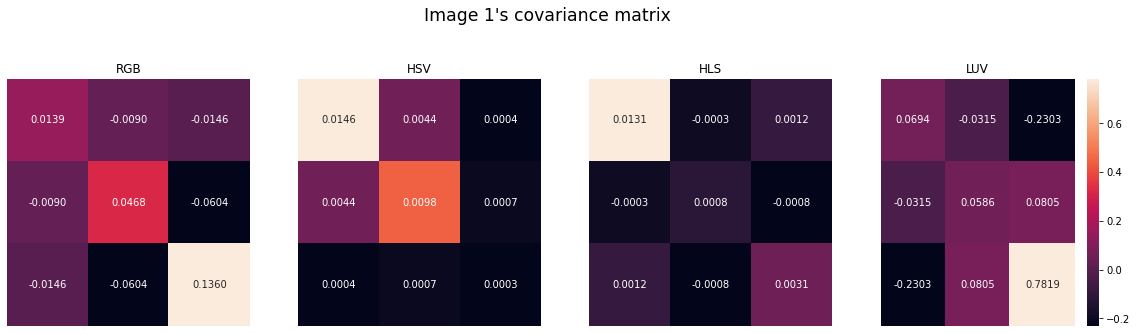

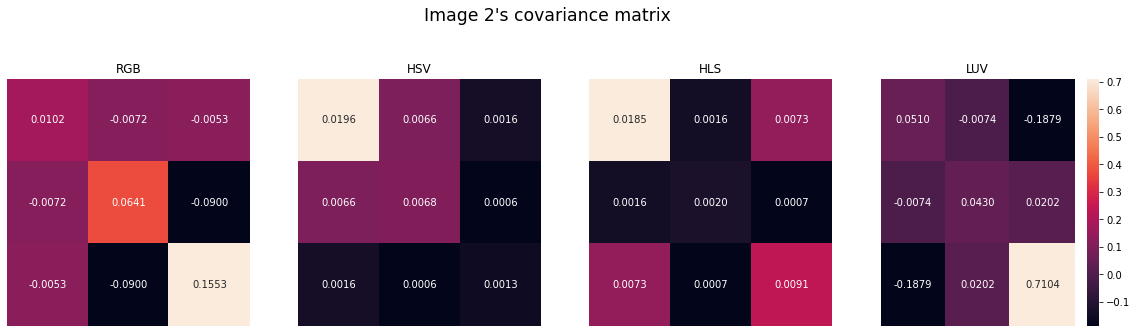

In [12]:
import seaborn as sns

mahalas = [[] for i in range(N2)]
for i in range(N2):
    pos = 1
    fig = plt.figure(figsize=(20,10))
    fig.suptitle("Image {0}'s covariance matrix".format(i+1), size="xx-large")
    for fg, cspace in zip(foregrounds[i], color_spaces):
        mahala = []
        inv_cov = inv_cov_matrix(fg)
        plt.subplot(N2, n_spaces, pos).set_title(cspace[1])
        cbar = True if pos == n_spaces else False
        pos += 1
        sns.heatmap(inv_cov, annot=True, fmt='.4f', cbar=cbar, xticklabels=False, yticklabels=False)
        for px in fg:
            mahala.append(mahalanobis(px, mean, inv_cov))
        mahalas[i].append(mahala)
    plt.show()


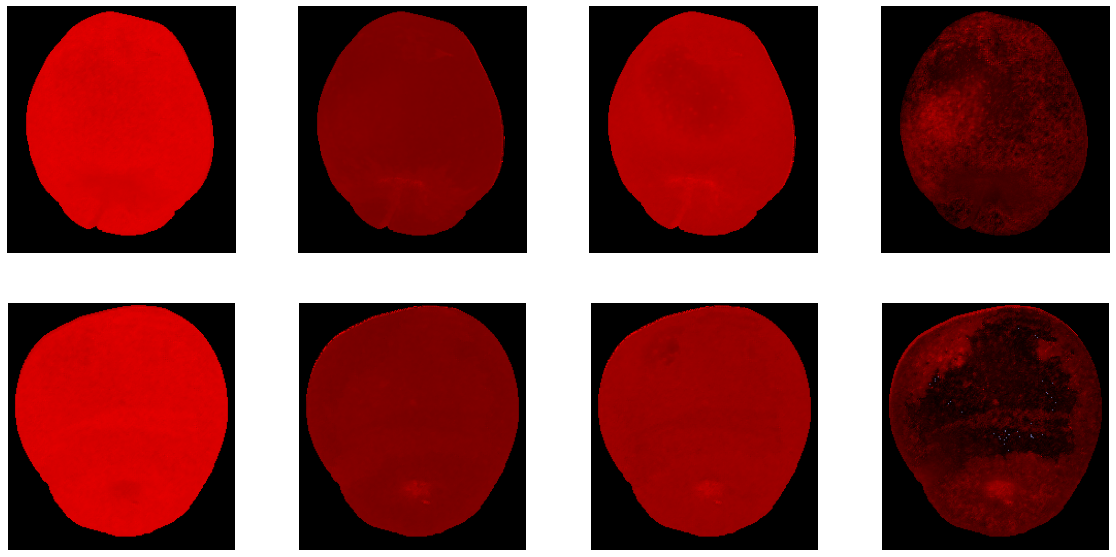

In [13]:
pos = 1
plt.figure(figsize=(20, 10))
for i in range(N2):
    for mahala, img in zip(mahalas[i], colored_images[i]):
        m, n, _ = img.shape
        new_img = np.copy(img)
        l = len(mahala)
        mmax = max(mahala)
        c = 0
        for j in range(m):
            for k in range(n):
                if (new_img[j,k,:] != [0,0,0]).any():
                    if (mahala[c] > 0):
                        new_img[j,k,:] = [mahala[c]*255/mmax,0,0]
                    c += 1
        plt.subplot(N2, n_spaces, pos).axis("off")
        pos += 1
        plt.imshow(new_img)
plt.show()

The above image shows graphically Mahalanobis distance: At each pixel of the foreground is associated a value \[x,0,0\], with x direcyly proportional to his Mahalanobis distance. It is clear that russet regions have a distance which is similar to the rest of the apple.
Only in LUV color space thing are a bit better: russet regions has a distinguishable low distance in the second image, but not in the first one. So a threshold can be obtained, but only for the second image.

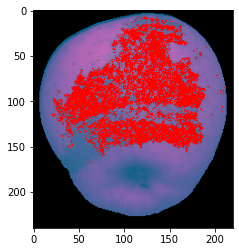

In [26]:
img = np.copy(colored_images[1][3])
m, n, _ = img.shape
mahala = mahalas[1][3]
l = len(mahala)
c = 0
for j in range(m):
    for k in range(n):
        if (img[j,k,:] != [0,0,0]).any():
            if (mahala[c] < 1.2):
                img[j,k,:] = [255,0,0]
            c += 1
plt.imshow(img)
plt.show()


## Eucledian Distance


In [ ]:
def euclidean_distance(x, y):
    x_minus_y = x -y
    return np.sqrt(np.matmul(x_minus_y.reshape(1,-1), x_minus_y))

In [ ]:
euclideans = [[] for i in range(N2)]
for i in range(N2):
    for fg in foregrounds[i]:
        eucl = []
        for px in fg:
            eucl.append(euclidean_distance(px, mean))
        euclideans[i].append(eucl)

Thresholds = [117, 106, 120, 23]


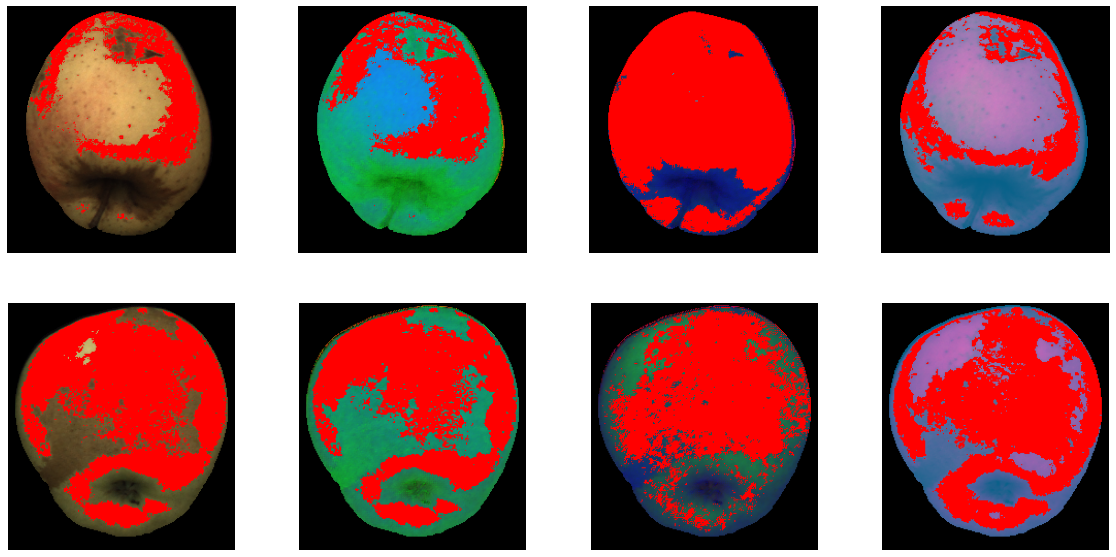

In [47]:
thresholds_eucl = [int((np.mean(euclideans[1][i])*1.0)) for i in range(n_spaces)]
print("Thresholds =", thresholds_eucl)

pos = 1
plt.figure(figsize=(20, 10))
for i in range(N2):
    for th, eucl, img in zip(thresholds_eucl, euclideans[i], colored_images[i]):
        m, n, _ = img.shape
        new_img = np.copy(img)
        l = len(mahala)
        c = 0
        for j in range(m):
            for k in range(n):
                if (new_img[j,k,:] != [0,0,0]).any():
                    if (eucl[c] < th):
                        new_img[j,k,:] = [255,0,0]
                    c += 1
        plt.subplot(N2, n_spaces, pos).axis("off")
        pos += 1
        plt.imshow(new_img)
plt.show()

Euclidean distance provide low-quality results